In [108]:
import wandb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

In [123]:
loss_key = "train/elbo"

In [124]:
# fit to
# L = C + B / (t**b)

def loss_curve(steps, C, B, b):
    return C + B * steps**(-b)

def fit_loss_curve(history, x_key="_step", y_key="train/elbo", min_x=2000, max_x=None):

    h = history.copy()
    if min_x is not None:
        h = h.loc[h[x_key] >= min_x]
    if max_x is not None:
        h = h.loc[h[x_key] <= max_x]
    popt, pcov = curve_fit(loss_curve, h[x_key], h[y_key], p0=(0.0, 1.0, 1.0), maxfev=10000)

    r2 = 1 - (np.sum((h[y_key] - loss_curve(h[x_key], *popt)) ** 2) / np.sum((h[y_key] - np.mean(h[y_key])) ** 2))

    y_hat = loss_curve(history[x_key], *popt)

    return y_hat, popt, r2


In [125]:
runs = wandb.Api().runs(
    path="dvruette/EasyDeL-diffusiontrainer-Gidd",
    filters={
        "tags": "critical_bs",
        # "config.aux_lr": 1e-3,
        "config.lr": 0.1,
        "config.batch_size": 16,
    }
)

histories = [
    run.history(keys=["train/loss", "train/elbo", "train/visited_tokens"])
    for run in runs
]

len(runs)

7

(2000, np.float64(145927.97909966463))

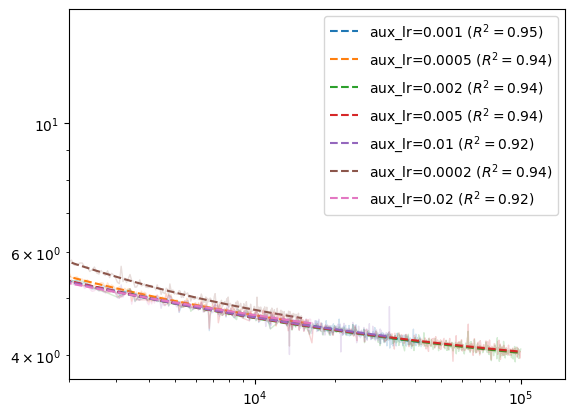

In [126]:
all_popts = []
lrs = [run.config.get("aux_lr") for run in runs]
for i, history in enumerate(histories):
    y_hat, popt, r2 = fit_loss_curve(history, y_key=loss_key, min_x=2000, max_x=None)
    all_popts.append(popt)

    plt.plot(history["_step"], history[loss_key], color=f"C{i}", linewidth=1.0, alpha=0.2)
    plt.plot(history["_step"], y_hat, label=f"aux_lr={lrs[i]} ($R^2={r2:.2f}$)", color=f"C{i}", linestyle="--")

    plt.legend()


plt.xscale("log")
plt.yscale("log")
plt.xlim(2000, None)
# plt.ylim(4, 5)

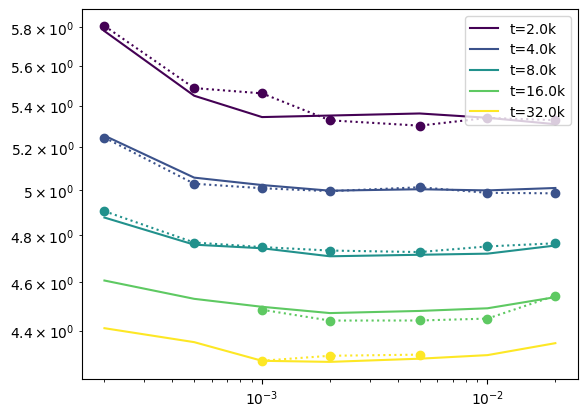

In [127]:
cmap = plt.get_cmap("viridis")

ts = np.logspace(np.log10(2000), np.log10(32000), 5)

# lrs = [run.config.get("lr") for run in runs]
lrs = [run.config.get("aux_lr") for run in runs]
for t in ts:
    ys = [loss_curve(t, *popt) for popt in all_popts]
    xs, ys = zip(*sorted(zip(lrs, ys)))
    color = cmap((np.log10(t) - np.log10(min(ts))) / (np.log10(max(ts)) - np.log10(min(ts))))

    plt.plot(xs, ys, label=f"t={t/1000:.1f}k", marker="none", color=color)

    y_true_ids = [history.loc[(history["_step"] - t).abs().sort_values().index[0], "_step"] for history in histories]
    y_true_smoothed = [history[loss_key].rolling(10, center=True).mean().loc[history["_step"] == idx] for idx, history in zip(y_true_ids, histories)]
    xs, y_true_smoothed = zip(*sorted(zip(lrs, y_true_smoothed)))
    plt.plot(xs, y_true_smoothed, marker="o", linestyle=":", color=color)

plt.xscale("log")
plt.yscale("log")
plt.legend(loc="upper right");


In [139]:
runs = []

for batch_size, lr, aux_lr in [
    (4, 0.1, 2e-3),
    (8, 0.1, 2e-3),
    (16, 0.1, 2e-3),
    (32, 0.2, 4e-3),
    (64, 0.2, 4e-3),
    # (128, 0.1, 2e-3),
]:
    runs += wandb.Api().runs(
        path="dvruette/EasyDeL-diffusiontrainer-Gidd",
        filters={
            "tags": "critical_bs",
            "config.batch_size": batch_size,
            "config.lr": lr,
            "config.aux_lr": aux_lr,
        }
    )

# runs = wandb.Api().runs(
#     path="dvruette/EasyDeL-diffusiontrainer-Gidd",
#     order="config.batch_size",
#     filters={
#         "tags": "critical_bs",
#         "config.aux_lr": 2e-3,
#         "config.lr": 0.1,
#         # "config.batch_size": 16,
#     }
# )

histories = [
    run.history(keys=["train/loss", "train/elbo", "train/visited_tokens"], samples=100000)
    for run in runs
]

len(runs)

5

In [140]:
popts = [fit_loss_curve(history, y_key=loss_key)[1] for history in histories]

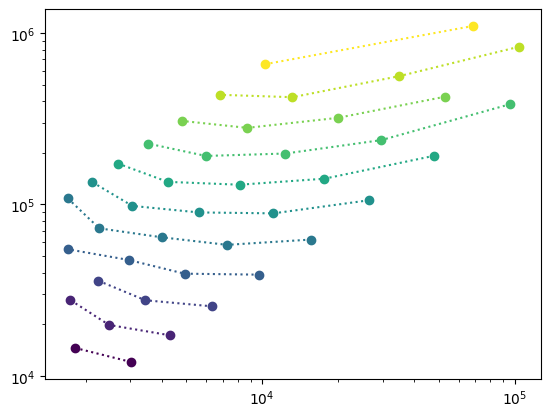

In [145]:
from scipy.optimize import fsolve


cmap = plt.get_cmap("viridis")

min_loss = 4.1
max_loss = 5.6
# min_loss = 0.67
# max_loss = 0.9

for target_loss in np.linspace(min_loss, max_loss, 11):
    # find x such that `loss_curve(x, *popt) = target_loss`
    steps = [
        fsolve(lambda x: loss_curve(x, *popt) - target_loss, 1.0)[0]
        for popt in popts
    ]


    color = cmap(1 - (target_loss - min_loss) / (max_loss - min_loss))

    batch_sizes = [run.config.get("batch_size") for run in runs]
    examples = [bs * t for bs, t, history in zip(batch_sizes, steps, histories) if t < 1.1*history["_step"].max() and t >= 1500]
    xs = [t for t, history in zip(steps, histories) if t < 1.1*history["_step"].max() and t >= 1500]
    # examples = [bs * t for bs, t, history in zip(batch_sizes, steps, histories)]
    # xs = [t for t, history in zip(steps, histories)]

    plt.plot(xs, examples, color=color, marker="o", linestyle=":")

    # steps = [
    #     history["_step"].loc[(history[loss_key].rolling(30, center=True).mean() - target_loss).abs().idxmin()]
    #     for history in histories
    # ]

    # print([
    #     history[loss_key].loc[(history[loss_key].rolling(30, center=True).mean() - target_loss).abs().idxmin()]
    #     for history in histories
    # ])

    # color = cmap(1 - (target_loss - min_loss) / (max_loss - min_loss))

    # batch_sizes = [run.config.get("batch_size") for run in runs]
    # examples = [bs * t for bs, t, history in zip(batch_sizes, steps, histories) if t < history["_step"].max() - 60*50]
    # xs = [t for t, history in zip(steps, histories) if t < history["_step"].max() - 60*50]
    # print(xs)
    # print(batch_sizes)

    # plt.scatter(xs, examples, color=color, marker="s")

plt.xscale("log")
plt.yscale("log")
# plt.xlim(2000, None)